In [1]:
import pandas as pd
import os
import glob

# ==========================================
# 1. 批量读取与合并
# ==========================================
# 假设你的文件都在这个文件夹里，如果没有文件夹，就填当前路径 '.'
# 建议你把智联招聘的 excel 都放在一个单独文件夹里
folder_path = "C:\\Users\\ffq73\\Desktop\\学习\\python泛数字\\大数据经济学\\大数据大作业\\智联招聘"  # <--- 请修改为你的实际文件夹路径
all_files = glob.glob(os.path.join(folder_path, "*.xlsx"))

df_list = []

for filename in all_files:
    try:
        temp_df = pd.read_excel(filename)
        # 如果文件名里包含城市信息（比如 '北京.xlsx'），可以提取作为来源
        # 但既然 E列 里有位置信息，我们稍后直接从 E列 提取更准确
        df_list.append(temp_df)
    except Exception as e:
        print(f"读取 {filename} 失败: {e}")

# 合并成一个大表
if len(df_list) > 0:
    df_zl = pd.concat(df_list, ignore_index=True)
    print(f"成功合并 {len(df_list)} 个文件，共 {len(df_zl)} 条数据")
else:
    # 如果你只有一个汇总好的大文件，直接用这一行读取：
    # df_zl = pd.read_excel('你的汇总文件.xlsx')
    print("未找到文件，请检查路径")

成功合并 6 个文件，共 29237 条数据


In [2]:
import re

# ==========================================
# 2. 数据清洗函数
# ==========================================

# --- A. 洗薪资 (C列: 1.2-2.4万 -> 平均值 18.0) ---
def clean_zl_salary(s):
    s = str(s)
    if '面议' in s or pd.isna(s):
        return None
    
    # 统一单位：如果是“万”，乘10；如果是原数字（8000），除1000
    try:
        # 提取数字部分
        nums = re.findall(r'\d+\.?\d*', s)
        if len(nums) < 2: return None
        low, high = float(nums[0]), float(nums[1])
        
        # 判断单位
        if '万' in s:
            return (low + high) / 2 * 10  # 1.2万 -> 12k
        elif '千' in s:
            return (low + high) / 2       # 8千 -> 8k
        else:
            # 假设是原始数值 (如 8000-12000)
            if low > 100: # 简单的阈值判断
                return (low + high) / 2 / 1000
            else:
                return (low + high) / 2 # 已经是k为单位了
    except:
        return None

# --- B. 洗位置 (E列: 深圳·龙岗 -> 深圳) ---
def get_city(s):
    if pd.isna(s): return '未知'
    # 截图显示是用 "·" 分隔的，取第一个就是城市
    return s.split('·')[0]

# --- C. 洗要求 (D列: 1-3年,大专 -> 分开) ---
def split_req(s, type_='edu'):
    # 假设格式是 "经验,学历" 或者 "学历,经验"
    # 我们用关键词匹配更稳妥
    s = str(s)
    edus = ['大专', '本科', '硕士', '博士', '学历不限', '中专', '高中']
    for e in edus:
        if e in s and type_ == 'edu':
            return e
            
    # 如果是找经验
    if type_ == 'exp':
        # 把学历剔除，剩下的就是经验
        for e in edus:
            s = s.replace(e, '').replace(',', '').replace('，', '')
        return s.strip()
    return '未知'

# --- D. 岗位分类 (核心需求) ---
def categorize_job_zl(title):
    t = str(title).lower()
    # 按照你的要求分类
    if any(x in t for x in ['保险', '核保', '理赔', '精算', '查勘']): return '保险'
    if any(x in t for x in ['财务', '会计', '审计', '出纳', '税务']): return '财务'
    if any(x in t for x in ['产品', '策划']): return '产品'
    if any(x in t for x in ['基金']): return '基金'
    if any(x in t for x in ['量化', '算法', '策略']): return '量化'
    if any(x in t for x in ['证券', '股票', '交易员']): return '证券'
    if any(x in t for x in ['银行', '柜员', '信贷']): return '银行'
    if any(x in t for x in ['投行', '保荐', '承销']): return '投行'
    if any(x in t for x in ['商业分析', '数据分析', 'bi', 'ba', '分析师']): return '商业/数据分析'
    if any(x in t for x in ['运营', '新媒体', '电商']): return '运营'
    if any(x in t for x in ['咨询', '顾问', '猎头']): return '咨询'
    return '其他'

# ==========================================
# 3. 应用清洗
# ==========================================
# 假设你的 DataFrame 叫 df_zl
# 请确保列名和你截图里的一样，如果不一样请修改下面的中括号内容

df_zl['avg_salary'] = df_zl['岗位薪资'].apply(clean_zl_salary)
df_zl['city'] = df_zl['公司位置'].apply(get_city)
df_zl['job_type'] = df_zl['岗位名称'].apply(categorize_job_zl)
df_zl['education'] = df_zl['岗位要求'].apply(lambda x: split_req(x, 'edu'))

# 剔除无法计算薪资的行
df_clean = df_zl.dropna(subset=['avg_salary'])
print("清洗完成！")

清洗完成！


二次清洗完成！剩余有效数据：21906 条


C:\Users\ffq73\AppData\Local\Temp\ipykernel_42620\2660945242.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=city_salary.index, y=city_salary.values, palette='viridis')


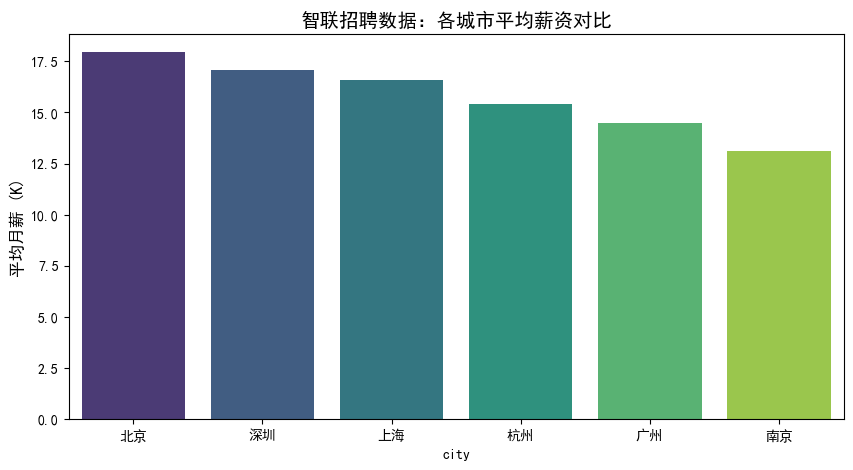

C:\Users\ffq73\AppData\Local\Temp\ipykernel_42620\2660945242.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=job_salary.index, y=job_salary.values, palette='magma')


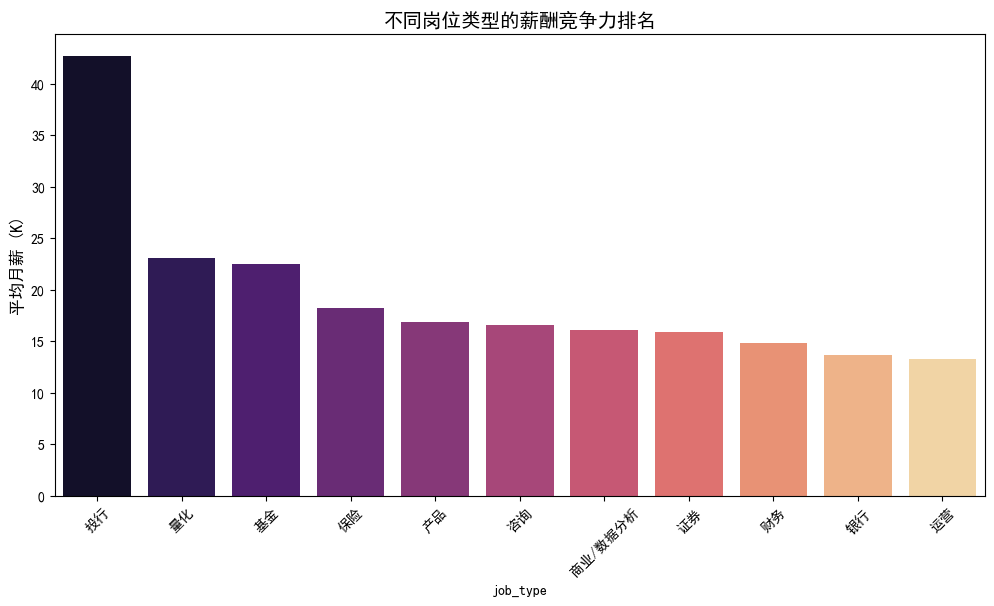

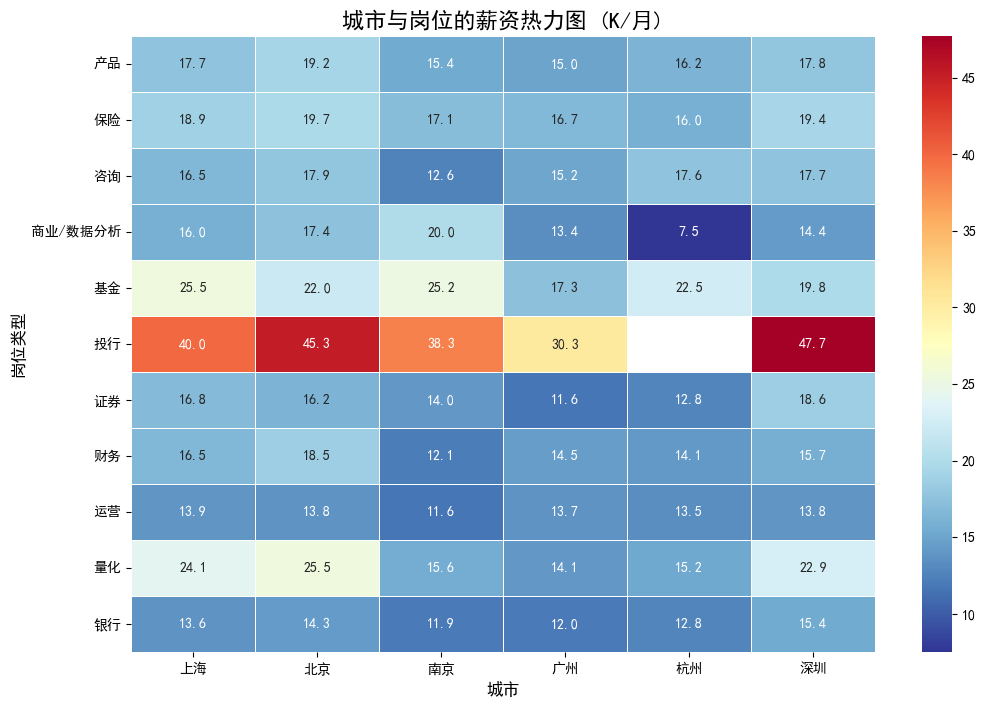

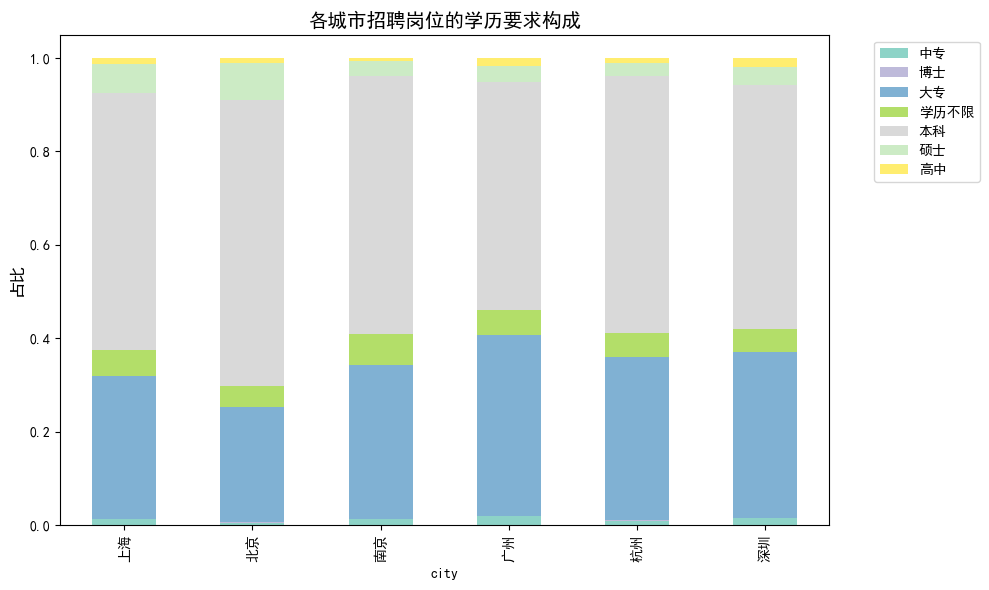

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
# ==========================================
# 0. 画图前的终极去噪 (剔除 "暂无" / "未知")
# ==========================================

# 1. 定义你要剔除的垃圾词列表
dirty_words = ['暂无', '未知', 'None', '其他', '不限']

# 2. 清洗城市列 (剔除包含垃圾词的城市)
# 逻辑：保留那些 城市名 不在垃圾列表里的行
df_clean = df_clean[~df_clean['city'].isin(dirty_words)]

# 3. 清洗学历列
df_clean = df_clean[~df_clean['education'].isin(dirty_words)]

# 4. 清洗岗位类型 (如果你不想看 "其他" 类岗位，也可以在这里删掉)
df_clean = df_clean[df_clean['job_type'] != '其他']

# 5. 再次确认有没有空值
df_clean = df_clean.dropna(subset=['city', 'education', 'job_type'])

print(f"二次清洗完成！剩余有效数据：{len(df_clean)} 条")

# -------------------------------------------------------
# (下面接你原本的画图代码 plt.figure... 那些)
# -------------------------------------------------------
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# ==========================================
# 图1：各城市岗位平均薪资对比 (Bar Chart)
# ==========================================
city_salary = df_clean.groupby('city')['avg_salary'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=city_salary.index, y=city_salary.values, palette='viridis')
plt.title('智联招聘数据：各城市平均薪资对比', fontsize=14)
plt.ylabel('平均月薪 (K)', fontsize=12)
plt.show()

# ==========================================
# 图2：不同岗位类型的薪资排名 (Bar Chart)
# ==========================================
# 过滤掉 "其他" 类，只看你关心的核心岗位
core_jobs = df_clean[df_clean['job_type'] != '其他']
job_salary = core_jobs.groupby('job_type')['avg_salary'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=job_salary.index, y=job_salary.values, palette='magma')
plt.title('不同岗位类型的薪酬竞争力排名', fontsize=14)
plt.ylabel('平均月薪 (K)', fontsize=12)
plt.xticks(rotation=45)
plt.show()

# ==========================================
# 图3：城市 x 岗位 热力图 (Heatmap) —— 核心分析图
# ==========================================
# 逻辑：横坐标是城市，纵坐标是岗位，颜色深浅代表工资高低
# 这张图能一眼看出：想做“量化”去哪个城市最赚钱？
pivot_data = core_jobs.pivot_table(index='job_type', columns='city', values='avg_salary', aggfunc='mean')

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_data, annot=True, fmt=".1f", cmap='RdYlBu_r', linewidths=0.5)
plt.title('城市与岗位的薪资热力图 (K/月)', fontsize=16)
plt.xlabel('城市', fontsize=12)
plt.ylabel('岗位类型', fontsize=12)
plt.show()

# ==========================================
# 图4：各城市对学历的要求分布 (Stacked Bar)
# ==========================================
# 看看哪个城市最卷学历？
edu_city = pd.crosstab(df_clean['city'], df_clean['education'])
# 归一化为百分比
edu_city_pct = edu_city.div(edu_city.sum(1), axis=0)

edu_city_pct.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='Set3')
plt.title('各城市招聘岗位的学历要求构成', fontsize=14)
plt.ylabel('占比', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

C:\Users\ffq73\AppData\Local\Temp\ipykernel_42620\4004889122.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('RdYlBu_r')


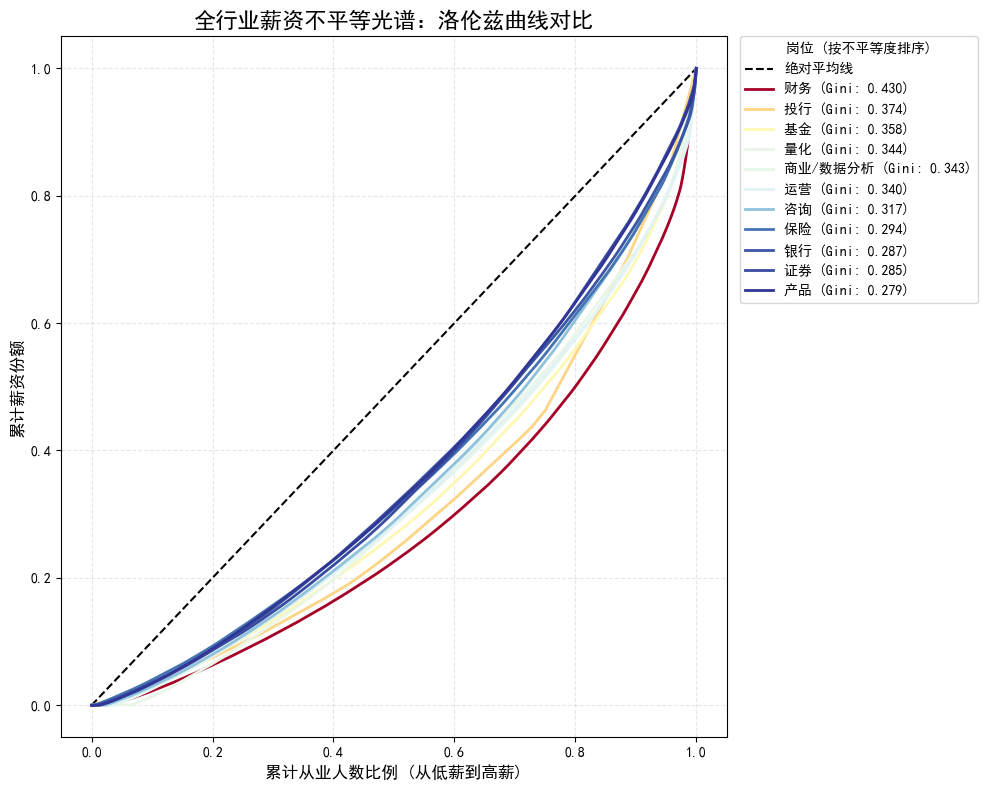

------ 岗位薪资不平等度排名 (从高到低) ------
         岗位      Gini
0        财务  0.430278
1        投行  0.373583
2        基金  0.357981
3        量化  0.343889
4   商业/数据分析  0.343291
5        运营  0.340465
6        咨询  0.316617
7        保险  0.294005
8        银行  0.287205
9        证券  0.284945
10       产品  0.279159


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm # 引入颜色映射库

# ==========================================
# 1. 准备数据：计算所有岗位的基尼系数
# ==========================================
# 假设 df_clean 是你清洗好的智联数据
job_types = df_clean['job_type'].unique()
gini_data = []

def calculate_gini(x):
    # 标准基尼系数计算函数
    x = np.array(x, dtype=np.float64)
    if np.any(x < 0): return 0
    if len(x) == 0: return 0
    sorted_x = np.sort(x)
    n = len(x)
    cumx = np.cumsum(sorted_x, dtype=np.float64)
    return (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n

# 遍历计算
for job in job_types:
    if job == '其他': continue # 跳过“其他”类
    salaries = df_clean[df_clean['job_type'] == job]['avg_salary'].values
    if len(salaries) > 10: # 样本太少不画，没意义
        g = calculate_gini(salaries)
        gini_data.append({'岗位': job, 'Gini': g})

# 转为 DataFrame 并排序 (关键！必须排序才能做渐变色)
gini_df = pd.DataFrame(gini_data).sort_values('Gini', ascending=False)

# ==========================================
# 2. 绘制全岗位洛伦兹曲线
# ==========================================
plt.figure(figsize=(10, 8))

# 画对角线 (绝对平均线)
plt.plot([0, 1], [0, 1], color='black', linestyle='--', linewidth=1.5, label='绝对平均线')

# 设置颜色映射 (从红到蓝：RdYlBu)
# 也就是：基尼系数越高越红，越低越蓝
norm = plt.Normalize(gini_df['Gini'].min(), gini_df['Gini'].max())
cmap = cm.get_cmap('RdYlBu_r') 

# 循环画每一条线
for idx, row in gini_df.iterrows():
    job_name = row['岗位']
    gini_val = row['Gini']
    
    # 提取该岗位的薪资数据
    salaries = np.sort(df_clean[df_clean['job_type'] == job_name]['avg_salary'].values)
    
    # 计算洛伦兹曲线坐标
    # Y轴：累计薪资占比
    y = np.cumsum(salaries) / salaries.sum()
    y = np.insert(y, 0, 0)
    # X轴：累计人数占比
    x = np.linspace(0, 1, len(y))
    
    # 根据基尼系数获取颜色
    color = cmap(norm(gini_val))
    
    # 画线 (linewidth设细一点，防止重叠太严重)
    plt.plot(x, y, color=color, linewidth=2, label=f"{job_name} (Gini: {gini_val:.3f})")

# ==========================================
# 3. 美化图表
# ==========================================
plt.title('全行业薪资不平等光谱：洛伦兹曲线对比', fontsize=16)
plt.xlabel('累计从业人数比例 (从低薪到高薪)', fontsize=12)
plt.ylabel('累计薪资份额', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)

# 关键：把图例放在图的外面，否则会挡住曲线
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, title="岗位 (按不平等度排序)")

# 调整布局防止切边
plt.tight_layout()
plt.show()

# 打印一下排名表，方便你写报告
print("------ 岗位薪资不平等度排名 (从高到低) ------")
print(gini_df.reset_index(drop=True))

In [5]:
!pip install pyecharts -i https://pypi.tuna.tsinghua.edu.cn/simple

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [7]:
# 1. 【补上缺失的库】
from pyecharts import options as opts  # <--- 刚才报错就是因为缺了这一句
from pyecharts.charts import Pie

# 2. 准备数据 (假设 df_clean 已经在之前的步骤里清洗好了)
# 如果 job_avg 还没算，这里重新算一下
job_avg = df_clean.groupby('job_type')['avg_salary'].mean().round(1).sort_values(ascending=False)
data_pair = [list(z) for z in zip(job_avg.index, job_avg.values)]

# 3. 绘制玫瑰图
c_rose = (
    Pie(init_opts=opts.InitOpts(width="1000px", height="600px", bg_color="white"))
    .add(
        "",
        data_pair,
        radius=["20%", "75%"], # 内圈和外圈半径
        center=["50%", "50%"],
        rosetype="radius", # 关键：设置为玫瑰图模式
        label_opts=opts.LabelOpts(is_show=True, formatter="{b}: {c}K"),
    )
    .set_global_opts(
        title_opts=opts.TitleOpts(title="商科各细分领域薪资竞争力 (玫瑰图)", pos_left="center"),
        legend_opts=opts.LegendOpts(is_show=False) # 隐藏图例，直接看标签
    )
    .set_series_opts(
        # 设置颜色渐变效果
        itemstyle_opts=opts.ItemStyleOpts(border_color="#fff", border_width=1)
    )
)

# 4. 渲染图表
# 加上这一句是为了防止网页白屏
from pyecharts.globals import CurrentConfig, OnlineHostType
CurrentConfig.ONLINE_HOST = OnlineHostType.NOTEBOOK_HOST

c_rose.render("san_chart.html")

'C:\\Users\\ffq73\\san_chart.html'

In [8]:
from pyecharts import options as opts
from pyecharts.charts import Bar3D
from pyecharts.globals import CurrentConfig

# 0. 稳定源配置 (防止白屏)
CurrentConfig.ONLINE_HOST = "https://assets.pyecharts.org/assets/"

# ==========================================
# 1. 准备数据
# ==========================================
# 筛选 Top 城市和 Top 岗位，防止图表太拥挤
# 取岗位数量最多的前8个城市，和前10个岗位类型
top_cities = df_clean['city'].value_counts().head(8).index.tolist()
top_jobs = df_clean[df_clean['job_type']!='其他']['job_type'].value_counts().head(10).index.tolist()

# 过滤数据
df_3d = df_clean[df_clean['city'].isin(top_cities) & df_clean['job_type'].isin(top_jobs)]

# 计算平均薪资矩阵
data_3d = []
for i, city in enumerate(top_cities):
    for j, job in enumerate(top_jobs):
        # 找到对应城市和岗位的平均薪资
        avg = df_3d[(df_3d['city']==city) & (df_3d['job_type']==job)]['avg_salary'].mean()
        if pd.notna(avg):
            # Bar3D 需要的数据格式：[x索引, y索引, z数值]
            data_3d.append([i, j, round(avg, 1)])

# ==========================================
# 2. 绘制 3D 柱状图
# ==========================================
c_3d = (
    Bar3D(init_opts=opts.InitOpts(width="1000px", height="600px", bg_color="white", page_title="薪资3D分布"))
    .add(
        "",
        data_3d,
        xaxis3d_opts=opts.Axis3DOpts(name="城市", type_="category", data=top_cities),
        yaxis3d_opts=opts.Axis3DOpts(name="岗位", type_="category", data=top_jobs),
        zaxis3d_opts=opts.Axis3DOpts(name="薪资(K)", type_="value"),
    )
    .set_global_opts(
        title_opts=opts.TitleOpts(title="全国商科薪资“摩天大楼”分布", pos_left="center"),
        visualmap_opts=opts.VisualMapOpts(
            max_=35,
            min_=5,
            range_color=["#313695", "#4575b4", "#74add1", "#abd9e9", "#e0f3f8", "#ffffbf", "#fee090", "#fdae61", "#f46d43", "#d73027", "#a50026"],
            pos_left="2%",
            pos_top="center"
        )
    )
)

# 输出
file_name_1 = "salary_3d_bar.html"
c_3d.render(file_name_1)
print(f"✅ 3D图表已生成！请打开文件【{file_name_1}】查看效果。")

✅ 3D图表已生成！请打开文件【salary_3d_bar.html】查看效果。


In [10]:
from pyecharts.charts import TreeMap
from pyecharts import options as opts
from pyecharts.globals import CurrentConfig, OnlineHostType

# 0. 稳定源配置
CurrentConfig.ONLINE_HOST = "https://assets.pyecharts.org/assets/"

# ==========================================
# 1. 准备分层数据 (这一步逻辑不变)
# ==========================================
# 假设 df_clean 是智联招聘的数据
# 我们只取 Top 5 城市，每个城市取 Top 5 岗位，防止图太碎
try:
    top_cities = df_clean['city'].value_counts().head(5).index.tolist()
    tree_data = []

    for city in top_cities:
        city_df = df_clean[df_clean['city'] == city]
        # 该城市下的岗位分布
        job_counts = city_df['job_type'].value_counts().head(5)
        
        children = []
        for job, count in job_counts.items():
            # 计算该城市该岗位的平均薪资（用于展示）
            avg_sal = city_df[city_df['job_type'] == job]['avg_salary'].mean()
            children.append({
                "name": f"{job}\n({avg_sal:.1f}K)", # 显示名字和薪资
                "value": int(count), # 面积代表岗位数量
                "salary": round(avg_sal, 1) # 存个数据方便提示框调用
            })
        
        tree_data.append({
            "name": city,
            "value": int(job_counts.sum()),
            "children": children
        })
except NameError:
    print("⚠️ 警告：找不到 df_clean 数据，请确保智联招聘数据清洗代码已运行。")
    tree_data = [] # 空数据防止后续报错

# ==========================================
# 2. 绘制矩形树图 (关键修复部分)
# ==========================================
c_tree = (
    TreeMap(init_opts=opts.InitOpts(width="1000px", height="600px", bg_color="white", page_title="就业全景图"))
    .add(
        series_name="岗位分布",
        data=tree_data,
        leaf_depth=1, # 默认显示到第几层
        # 标签显示格式
        label_opts=opts.LabelOpts(position="inside", formatter="{b}"),
        
        # ---【关键修改】这里改用字典格式，不再调用报错的类 ---
        levels=[
            # 第一层级（城市）的样式
            {
                "itemStyle": {
                    "borderColor": "#555",
                    "borderWidth": 4,
                    "gapWidth": 4
                }
            },
            # 第二层级（岗位）的样式
            {
                "colorSaturation": [0.3, 0.6], # 颜色饱和度范围
                "itemStyle": {
                    "gapWidth": 2,
                    "borderColorSaturation": 0.7,
                    "borderWidth": 2
                }
            }
        ]
        # ----------------------------------------------------
    )
    .set_global_opts(
        title_opts=opts.TitleOpts(title="商科就业市场：城市与岗位的供需结构 (TreeMap)", pos_left="center"),
        tooltip_opts=opts.TooltipOpts(formatter="{b}: <br/>招聘人数: {c}"),
        # 隐藏图例，让图表更清爽
        legend_opts=opts.LegendOpts(is_show=False)
    )
)

# 输出
file_tree = "treemap_market.html"
c_tree.render(file_tree)
print(f"✅ 矩形树图已生成！请去文件夹打开【{file_tree}】。")

✅ 矩形树图已生成！请去文件夹打开【treemap_market.html】。
